This notebook provides examples of how to calculate the steady state of a Boolean Network (BN) or a Probabilistic Boolean Network (PBN).

# PBN steady states

Steady-state calculation capabilities for both Boolean Networks and Probabilistic Boolean Networks in BNMPy.  
Refer to the `pbnStationary_TS.m` function in the `optPBN` MATLAB package.

In [2]:
import sys
import numpy as np
sys.path.append('./src')
import BNMPy

In [3]:
network_string = """
N1 = N1, 1
N2 = N2, 1
N3 = N1, 0.6
N3 = N1 & !N2, 0.4
"""
x0  =  np.array( [1, 1, 0] )  # initial state
network = BNMPy.load_pbn_from_string(network_string, initial_state = x0)

PBN loaded successfully. There are 3 genes in the network.


## Monte Carlo Method

1. Performs several independent simulations from initial conditions
2. Update with noise for dynamics
3. Takes the mean across all runs and the second half of each trajectory

**Parameters**:

- `n_runs` (int, default=10): Number of independent simulation runs
- `n_steps` (int, default=1000): Number of simulation steps per run
- `p_noise` (float, default=0): Noise probability for `update_noise()`
- `seed` (int, default=None): Seed for random number generator

In [4]:
calc = BNMPy.SteadyStateCalculator(network)
steady_state = calc.compute_steady_state(method='monte_carlo',n_runs=20,n_steps=20000,p_noise=0, seed = 9)
steady_state

array([1.        , 1.        , 0.59975502])

When there is no noise, the steady state will start with the predefined initial state and be trapped in it.   
Therefore we get 1s for N1 and N2, and 0.6 for N3 because there is 0.6 probability that N1 is 1.

In [5]:
calc = SteadyStateCalculator(network)
steady_state = calc.compute_steady_state(method='monte_carlo',n_runs=20,n_steps=20000,p_noise=0.05, seed = 9)
steady_state

array([0.50837416, 0.49609039, 0.41387861])

When there is noise, the initial state is quickly forgotten because noise is independent of the state and drives both self-loops for N1 and N2 toward a uniform 0.5–0.5 equilibrium.  
For N3, there are two possibilities:
- f(N) = N1 (with p=0.6)         =>   expected value is 0.6*0.5=0.3
- f(N) = N1 & !N2 (with p=0.4)   =>   expected value is 0.4\*0.5\*0.5=0.1
  
Therefore, the steady state for N3 is 0.3+0.1=0.4.


For Monte Carlo method, it would always be nice to check if the network has converged for the given number of steps.  
This can be done by adding arguments `analyze_convergence=True` and specify the output node for convergence analysis `output_node='N3'`.

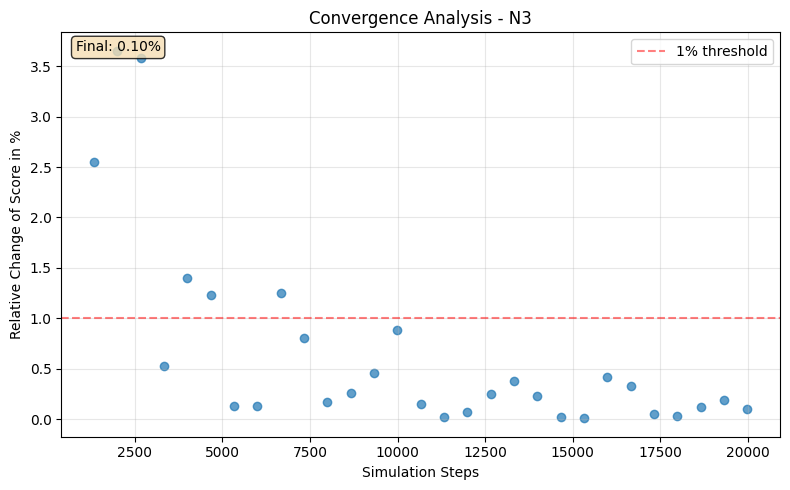

array([0.53114689, 0.52154785, 0.42345765])

In [9]:
calc = BNMPy.SteadyStateCalculator(network)
steady_state, convergence_info = calc.compute_steady_state(method='monte_carlo',n_runs=20,n_steps=20000,p_noise=0.05, seed = 9, analyze_convergence=True, output_node='N3')
steady_state

## TSMC Method

1. Runs multiple rounds of network simulation
2. Uses transition probability analysis to determine required simulation length
3. Calculates how many initial steps to discard (burn-in period)
4. Ensures results meet specified statistical accuracy requirements
5. In addition to the original function, `freeze_constant` ensure similar behavior to MC method
 - freeze_constant=False: MC with noise
 - freeze_constant=True: MC with no noise


**Parameters**:

- `epsilon` (float, default=0.001): Range of transition probability (smaller = more accurate)
- `r` (float, default=0.025): Range of accuracy - most sensitive parameter (smaller = more accurate)
- `s` (float, default=0.95): Probability of accuracy (closer to 1 = more confident)
- `p_noise` (float, default=0): Noise probability for Monte Carlo method
- `p_mir` (float, default=0.001): Perturbation probability (Miranda-Parga scheme)
- `initial_nsteps` (int, default=1000): Initial number of simulation steps
- `max_iterations` (int, default=100): Maximum convergence iterations
- `freeze_constant` (bool, default=False): Freeze constant nodes
- `seed` (int, default=None): Seed for random number generator

**Fix**:  

In the original MATLAB code, pure identity rules such as A(t+1)=A(t) are treated as inputs and are therefore never perturbed; during Monte-Carlo estimation each iteration starts from a fresh random initial state, so the long-run mean of a self-loop naturally converges to 0.5. The TSMC approach, however, draws one random initial state and keeps it fixed for the entire trajectory. 

freeze_constants=False allows TSMC and Monte-Carlo converge to identical stationary distributions with similar perturbation probability.

In [8]:
calc = SteadyStateCalculator(network)
steady_state = calc.compute_steady_state(method='tsmc',r=0.01,initial_nsteps=100,max_iterations=5000,freeze_constant=True, seed = 9)
steady_state

array([1.        , 1.        , 0.59662553])

In [9]:
calc = SteadyStateCalculator(network)
steady_state = calc.compute_steady_state(method='tsmc',r=0.01,p_mir=0.01,initial_nsteps=100,max_iterations=5000,freeze_constant=False, seed = 9)
steady_state

array([0.50082694, 0.506649  , 0.39982888])

## Perturbations

Apply experimental perturbations by fixing certain nodes to specific values.

**Parameters**:

- `stimuli` (list): Node names to fix at value 1
- `stimuli_efficacy` (list): Efficacy of stimuli (between 0 and 1)
- `inhibitors` (list): Node names to fix at value 0
- `inhibitors_efficacy` (list): Efficacy of inhibitors (between 0 and 1)
- `node_dict` (dict): Mapping from node names to indices (uses `network.nodeDict` if None)

Note that the efficacy option is only available for Monte Carlo method.

In [10]:
network_string = """
N1 = N1, 1
N2 = N2, 1
N3 = N1, 0.6
N3 = N1 & !N2, 0.4
"""
x0  =  np.array( [1, 1, 0] )  # initial state
network = BMatrix.load_pbn_from_string(network_string, initial_state = x0)
calc = SteadyStateCalculator(network)

PBN loaded successfully. There are 3 genes in the network.


In [4]:
calc.set_experimental_conditions(stimuli=['N1'])
calc.compute_steady_state(method='monte_carlo',n_runs=20,n_steps=10000,p_noise=0)

array([1., 0., 1.])

In [10]:
calc.set_experimental_conditions(stimuli=['N2'])
calc.compute_steady_state(method='monte_carlo',n_runs=20,n_steps=10000,p_noise=0)

array([0., 1., 0.])

In [13]:
calc.set_experimental_conditions(stimuli=['N1'],stimuli_efficacy=[0.5],inhibitors=['N2'],inhibitors_efficacy=[0.5])
calc.compute_steady_state(method='monte_carlo',n_runs=20,n_steps=10000,p_noise=0.05, seed = 9)

array([0.50102979, 0.49822036, 0.41082783])

# BN steady states

Find attractors (fixed points and cycles) in a synchronous Boolean network via random restarts.
  
Parameters:
- `n_runs` : int, default=100
    Number of random initial conditions to try
- `n_steps` : int, default=1000
    Maximum number of steps to simulate before declaring no cycle found
- `verbose` : bool, default=True
    Whether to print steady state information
- `seed` : int, optional
    Random seed for reproducibility

In [2]:
# the Ikonomi 2020 model
network_string = """
EXTERNAL_QUIESCENCE = EXTERNAL_QUIESCENCE 
EXTERNAL_CYCLING = EXTERNAL_CYCLING 
PIK3CA = NRAS 
TSC1 = !AKT1
MTOR = !TSC1 
FOXO3 = (EXTERNAL_QUIESCENCE) & !AKT1
ATM = FOXO3
ROS1 = MITOCHONDRIA | !ATM | !FOXO3 | !BMI1 | !TP53
MITOCHONDRIA = MTOR
AUTOPHAGY = FOXO3 & ROS1 & !MTOR 
NRAS = EXTERNAL_CYCLING
ETS = NRAS & !MEFV
MEFV = NRAS
GSK3B = !AKT1
CTNNB1 = !GSK3B
MYC = CTNNB1 & !GSK3B
BMI1 = MYC | (ATM & FOXO3)
MDM2 = (TP53 | MEFV) & !CDKN2D & !ATM
TP53 = !MDM2  
CDKN1C = EXTERNAL_QUIESCENCE | FOXO3 
CDKN1A = (TP53 | FOXO3 | EXTERNAL_QUIESCENCE |GFI1) & !MYC
CDKN1B = FOXO3
GFI1 = TP53
RB1 = !CCND1 & !CCNE1
E2F1 = !RB1  & !GFI1  
CCND1 = !CDKN2A & !CDKN1C & MYC 
CCNE1 = (!CDKN1C) & ((!CDKN1A & !CDKN1B) | CCND1) & (E2F1)
S_PHASE = CCNE1 & E2F1
AKT1 = PIK3CA
CDKN2D = !BMI1 & (E2F1 | ROS1)
CDKN2A = (ETS | ROS1) & !BMI1 
PRO_APOPTOTIC_PROTEINS = TP53 &  ROS1 & !AKT1
ANTI_APOPTOTIC_PROTEINS = (NRAS | EXTERNAL_QUIESCENCE) & !GSK3B
CYCS = PRO_APOPTOTIC_PROTEINS & !ANTI_APOPTOTIC_PROTEINS
APOPTOSIS = CYCS & !AKT1 
SENESCENCE = (CDKN2A & ROS1) | (TP53 & ROS1 & CDKN1A) 
"""
network = BMatrix.load_network_from_string(network_string)

No initial state provided, using a random initial state
Network loaded successfully. There are 36 genes in the network.


In [3]:
calc = SteadyStateCalculator(network)
steady_state = calc.compute_steady_state(n_runs=100,n_steps=1000)

Found 4 fixed points and 0 cyclic attractors
Fixed points: 
Fixed point 1: [1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Fixed point 2: [0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0]
Fixed point 3: [1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0]
Fixed point 4: [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1]
--------------------------------
No cyclic attractors found
--------------------------------
Node order: dict_keys(['EXTERNAL_QUIESCENCE', 'EXTERNAL_CYCLING', 'PIK3CA', 'TSC1', 'MTOR', 'FOXO3', 'ATM', 'ROS1', 'MITOCHONDRIA', 'AUTOPHAGY', 'NRAS', 'ETS', 'MEFV', 'GSK3B', 'CTNNB1', 'MYC', 'BMI1', 'MDM2', 'TP53', 'CDKN1C', 'CDKN1A', 'CDKN1B', 'GFI1', 'RB1', 'E2F1', 'CCND1', 'CCNE1', 'S_PHASE', 'AKT1', 'CDKN2D', 'CDKN2A', 'PRO_APOPTOTIC_PROTEINS

In [4]:
steady_state

{'fixed_points': [array([1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1,
         1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int8),
  array([0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0,
         0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0], dtype=int8),
  array([1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0,
         0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0], dtype=int8),
  array([0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
         1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1], dtype=int8)],
 'cyclic_attractors': []}